## Autocorrelation with Dask, parallel 

The goal is to use dask to carry out spatial autocorrelation in parallel on multiple blocks.
The keys functions are map_overlap and the autocorrelation function in data_analysis >> eshelby_inclusion

Outline
- Import libraries
- Create synthetic data of 10 x 10 grid
- Decide on auto-correlation shift vectors of, say 3x3
- Compute autocorrelation acros the entire grid to check that dask splittig is working as expected
- Create 2x2 chunks on the synth data
- Map overlap, with added meta data information that the output array is not the same dimensions as the input array
- Combine the output array to get the same output as the full autocorrelation across the entire grid. 
- Extend to 3D

Extensions: make the code reusable so that in principle I could do the following as the input is still an array of scalars onto which I want to compute spatial correlations
- The strain field is coarse grained (This should only change the rescale dimensions of the input and and rescale the shift vectors)
- Scalar metrics of angular correlations: 
     - Correlate the angle of maximum principle strain direction projected in plane of the shear direction 
     - and similarily the angle out of plane of the shear direction 
     - I think its the three euler angles to rotate the strain ellipsoid with eignevalues in descending order (l1, l2, l3:
       -  l1 - l3 -> x ~ direction of grid motion (maximum shear strain direction gets rotated onto grid displacement)
       - vector normal to l1-l3 that is right handed coordinate system with z going up -> y ~ direction perpendicular to grid motion, in the plane of the grid 
       - l2 -> perpendicular to the grid, point up
       - I think in the limit of linear elastic and simple shear, the strain ellipsoid would look like a needle pointing direction of applied strain
       - In the limit of plane strain, the strain ellipsoid would be a thin disk in the plane of the shear plate. 
       - In both of these limiting cases, the autocorrelations should not decay spatially as the strain field is constant thorughout the body (in both magnitude and direction)

In [17]:
# import libraries
import numpy as np
import dask.array as da
import numba

import sys
sys.path.extend(['/Users/zsolt/Colloid_git/TractionRheoscopy'])
from data_analysis import eshelby_inclusion as slb
import tifffile
from scipy.interpolate import griddata

In [67]:
# create synthetic 10x10 grid
# reshape gives the dimensions of the output grid, not the number of chunks
A = np.arange(100).reshape((10,10))
A_random = np.random.random_sample((10,10))

# convert to dask array with 4 chunks total
# also note that chunks specified are again the dimensions, not the number of chunks
A_da = da.from_array(A, chunks=(5,5))
A_random_da = da.from_array(A_random, chunks=(5,5))

In [68]:
A_da

dask.array<array, shape=(10, 10), dtype=int64, chunksize=(5, 5), chunktype=numpy.ndarray>

In [70]:
# what does the 3x3 autocorrelation of this small array give?
slb.spatialCorr(np.array([A]),np.array([A]),(0,3,3))

array([[[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]]])

In [23]:
@numba.jit(nopython=True)
def spatialCorr(A,B,k):
    """
    Computes the spatial correlation of arrays A and B over the shift vectors with magnitude less than k

    :param A: numpy array, possibly 3D
    :param B: numpy array, possibly 3D
    :param k: tuple, giving the max value of shift vectors to move B on top of A

    return: numpy array of dimension 2k with values equal to the normalize autocorrelation (ie covariance)
            of B shifted by ij, relative to A.
    """
    out = np.zeros((2*k[0]+1, 2*k[1] + 1, 2*k[2] +1))
    for kz in range(-1*k[0],k[0]+1):
        for ky in range(-1*k[1],k[1]+1):
            for kx in range(-1*k[2],k[2]+1):
                if kz == 0:
                    if ky > 0:
                        if kx > 0:    a, b = A[:, ky:,  kx: ], B[:, :-1*ky, :-1*kx  ]
                        elif kx < 0:  a, b = A[:, ky:, :kx  ], B[:, :-1*ky,  -1*kx: ]
                        else:         a, b = A[:, ky:, :    ], B[:, :-1*ky, :       ]
                    elif ky < 0:
                        if kx > 0:    a, b = A[:, :ky,  kx: ], B[:, -1*ky:, :-1 * kx  ]
                        elif kx < 0:  a, b = A[:, :ky, :kx  ], B[:, -1*ky:,  -1 * kx: ]
                        else:         a, b = A[:, :ky, :    ], B[:, -1*ky:, :         ]
                    else:
                        if kx > 0:    a, b = A[:, :  ,  kx: ], B[:, :, :-1 * kx  ]
                        elif kx < 0:  a, b = A[:, :  , :kx  ], B[:, :,  -1 * kx: ]
                        else:         a, b = A[:, :  , :    ], B[:, :, :         ]

                elif kz > 0:
                    if ky > 0:
                        if kx > 0:    a, b = A[kz:, ky:,  kx: ], B[:-1*kz, :-1*ky, :-1*kx  ]
                        elif kx < 0:  a, b = A[kz:, ky:, :kx  ], B[:-1*kz, :-1*ky,  -1*kx: ]
                        else:         a, b = A[kz:, ky:, :    ], B[:-1*kz, :-1*ky, :       ]
                    elif ky < 0:
                        if kx > 0:    a, b = A[kz:, :ky,  kx: ], B[:-1*kz, -1*ky:, :-1 * kx  ]
                        elif kx < 0:  a, b = A[kz:, :ky, :kx  ], B[:-1*kz, -1*ky:,  -1 * kx: ]
                        else:         a, b = A[kz:, :ky, :    ], B[:-1*kz, -1*ky:, :         ]
                    else:
                        if kx > 0:    a, b = A[kz:, :  ,  kx: ], B[:-1*kz, :, :-1 * kx  ]
                        elif kx < 0:  a, b = A[kz:, :  , :kx  ], B[:-1*kz, :,  -1 * kx: ]
                        else:         a, b = A[kz:, :  , :    ], B[:-1*kz, :, :         ]

                else:
                    if ky > 0:
                        if kx > 0:    a, b = A[:kz, ky:,  kx: ], B[-1*kz:, :-1*ky, :-1*kx  ]
                        elif kx < 0:  a, b = A[:kz, ky:, :kx  ], B[-1*kz:, :-1*ky,  -1*kx: ]
                        else:         a, b = A[:kz, ky:, :    ], B[-1*kz:, :-1*ky, :       ]
                    elif ky < 0:
                        if kx > 0:    a, b = A[:kz, :ky,  kx: ], B[-1*kz:, -1*ky:, :-1 * kx  ]
                        elif kx < 0:  a, b = A[:kz, :ky, :kx  ], B[-1*kz:, -1*ky:,  -1 * kx: ]
                        else:         a, b = A[:kz, :ky, :    ], B[-1*kz:, -1*ky:, :         ]
                    else:
                        if kx > 0:    a, b = A[:kz, :  ,  kx: ], B[-1*kz:, :, :-1 * kx  ]
                        elif kx < 0:  a, b = A[:kz, :  , :kx  ], B[-1*kz:, :,  -1 * kx: ]
                        else:         a, b = A[:kz, :  , :    ], B[-1*kz:, :, :         ]
                #out[kz, ky, kx] = (np.mean(a * b) - np.mean(a) * np.mean(b)) / (np.sqrt(np.var(a)) * np.sqrt(np.var(b)))
                # that line is wrong...as the shift vector k is not the same as the array index.
                out[kz + k[0], ky + k[1] ,kx + k[2]] = (np.mean(a * b) - np.mean(a) * np.mean(b)) / (np.sqrt(np.var(a)) * np.sqrt(np.var(b)))

    return out

In [71]:
out = slb.spatialCorr(np.array([A_random]),np.array([A_random]),(0,3,3)).squeeze()

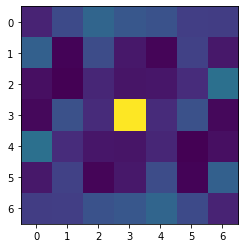

In [72]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(out, interpolation='none')
plt.show()

### Comments on symmetry of auto- and cross-correlations

Cross correlations have the property cross_AB(kx,ky) = cross_BA(-kx,-ky), without additional symmetry requirements on the signal.  

However this symmetry is typically not even accidently visualized as it requires permuting the arguments. If you keep the arguement order fixed, by for example requiring that ideal eshelby always be the 2nd argument so crossCorrs(exptField, elasticSoln) means "field is cross correlated with elastic solution," then you have not have any gauranteed symettries.  
Even if the elastic field has symetry, the cross correlation with random field will be random. (check ?)
Some hypotheses to check:
> crossCorr(random, leftRightMirror) -> none  
 crossCorr(random, topDownMirro) -> none  
crossCorr(random, twoMirrorPlanes) -> none    
crossCorr(random, inversionCenterNoMirror) -> none    
crossCorr(leftRightMirror, leftRightMirror) -> crossAB(kx,ky) = cross_AB(-x,ky)  
crossCorr(leftRightMirror, topDownMirror) -> none  
crossCorr(leftRightMirror, twoMirrors) -> crossAB(kx,ky) =crossAB(-kx,ky)  
corssCorr(leftRightMirror, inversionCenter) -> crossAB(kx,ky) =  

Hypothesis -> cross correlations will preserve only those symmetries present in *both* signals. 


Autocorrelations always an inversion center with no additional symmetry requirements on the signal:   
> autoCorr_A(kx,ky) = autoCorr_A(-kx -ky) 

which is an easy consequence of the above cross correlation symmetry:  
> autoCorr_A(kx,ky) = crossCorr_AA(kx,ky) =* crossCorr_AA(-kx,-ky) = autoCorr(-kx,-ky)which is an inversion symmetry...not a mirror.  

where in the =* step involved trivally permute indices and apply the symmetry   


## Moving onto map overlap in dask
- set shift vector to be 1 and overlap to be 2.
- note the example from docs.dask

In [5]:
from dask.distributed import Client, LocalCluster

### Interpolate onto grid


#### Import partial particle locations from Aidan's series of ~100k particles

In [3]:
import pandas as pd
import dask
path_partial = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/locations_stitch/partial_data_Aidan/'
fName_frmt = 'shearRun10292018f_centerParticles_t{:02}.h5'

In [5]:
# try parallel using dask delayed
def loadParticle(t):
    pos_t = pd.read_hdf(path_partial + fName_frmt.format(t))
    idx_t = pd.MultiIndex.from_product([[t],pos_t.index], names = ['frame', 'particle'] )
    return pos_t.set_index(idx_t)

In [29]:
# this is almost perfect except I should specify the ip address for the cluster, and then use the
# ip for all of these subprocesses dask clusters. 
posList = []
with LocalCluster(n_workers=6, threads_per_worker=4, memory_limit='8Gb') as node, Client(node) as client:  
    for t in range(40):
        tmp = dask.delayed(loadParticle)(t)
        posList.append(tmp)
    pos = pd.concat(dask.compute(*posList))
    

In [368]:
pos;

In [369]:
pos.loc[([0,9],slice(None)),:][['x (um, imageStack)','y (um, imageStack)', 'z (um, imageStack)']];

### Import full positions and strain

In [2]:
%%time
import pandas as pd
import dask

hdf_stem= '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/locations_stitch/'
pos_fName = 'tfrGel10212018A_shearRun10292018f_sed_stitched_pandas.h5'
strain_fName = 'tfrGel10212018A_shearRun10292018f_sed_strainTrajZeroRef.h5'
pos = pd.read_hdf(hdf_stem + pos_fName)
strain_ref0 = pd.read_hdf(hdf_stem + strain_fName)

CPU times: user 16.7 s, sys: 10.1 s, total: 26.8 s
Wall time: 26.8 s


In [6]:
from data_analysis import static
def computeStrain_dask(pos_df, tPair, output = 'strainTraj', pos_keys=None, verbose=False):
    """
    Make LocalStrainTraj on a list of time points
    tPairs = list(zip([0 for n in range(90)],[n for n in range(2,90)]))

    This is a wrapper.  Mostly handles formatting the dataFrames.
    """ 
    ref = tPair[0]
    cur = tPair[1]
    strain_traj = static.localStrain(pos_df,ref,cur,pos_keys=pos_keys)
    #strain_traj = localStrain(pos_df, 0, 1, pos_keys = pos_keys)
    strain_traj = strain_traj.stack().rename('({},{})'.format(ref,cur)).to_frame()
    strain_traj.set_index(strain_traj.index.rename(['particle', 'values']), inplace=True)
    if output == 'hdf':
        raise KeyError('Saving strainTraj directly to hdf is not implemented yet')
        #strain_fName = 'tfrGel10212018A_shearRun10292018f_sed_strainTraj_consecutive.h5'
        #strain_traj.to_hdf(hdf_stem + strain_fName, '(0,t)', mode='a', format='table', data_columns=True)
    elif output == 'strainTraj':
        return strain_traj
    else: raise KeyError('output {} not recognized'.format(output))

In [5]:
tPairs = list(zip([0 for n in range(39)],[n for n in range(1,40)]))
subPosList = [pos.loc[([t[0],t[1]],slice(None)),:][['x (um, imageStack)','y (um, imageStack)', 'z (um, imageStack)']] for t in tPairs]

In [7]:
with LocalCluster(n_workers=6, threads_per_worker=6, memory_limit='8Gb') as node, Client(node) as client:
    strainList = []
    
    for n in range(len(tPairs)):
        #sub_pos = pos.loc[([t[0],t[1]],slice(None)),:][['x (um, imageStack)','y (um, imageStack)', 'z (um, imageStack)']]
        strainFunc = lambda n: computeStrain_dask(subPosList[n],tPairs[n])
        strain_tmp = dask.delayed(strainFunc)(n)
        strainList.append(strain_tmp)
    tmp = dask.compute(*strainList)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/distributed/client.py", line 1349, in _close
    await self.scheduler_comm.close()
concurrent.futures._base.CancelledError


TimeoutError: timed out after 20 s.

In [7]:
# create a simple function to make a list of pairs with a given ref and cur configuration and all time points between them
def mkPair(ref,cur):
    out = []
    for t in range(1,cur-ref +1):
        out.append((ref, ref +t))
    return out
mkPair(3,8)

[(3, 4), (3, 5), (3, 6), (3, 7), (3, 8)]

In [8]:
# on full data set this takes...up a lot of ram
# 11Gb to load pos and strain ref0
# 13Gb to form subPosList. 
# default dask dash board at http://localhost:8787/status

#specialStrainPts = [(3,8),(7,22),(8,10),(22,23),(23,26)]
specialStrainPts = [(3,8)]
flatten = lambda t: [item for sublist in t for item in sublist]
#tPairList = [item for sublist in [mkPair(t[0],t[1]) for t in specialStrainPts] for item in sublist]

#specialStrainPts = [(3,8),(7,22),(8,10),(22,23),(23,26)]
tPairs = flatten([mkPair(t[0],t[1]) for t in specialStrainPts])
subPosList = [pos.loc[([t[0],t[1]],slice(None)),:][['x (um, imageStack)','y (um, imageStack)', 'z (um, imageStack)']] for t in tPairs]

In [10]:
tPairs

[(3, 4), (3, 5), (3, 6), (3, 7), (3, 8)]

In [12]:
from dask.distributed import Client, LocalCluster
with LocalCluster(n_workers=2, threads_per_worker=6, memory_limit='16Gb') as node, Client(node) as client:
    strainList = []
    for n in range(len(tPairs)):
        strainFunc = lambda n: computeStrain_dask(subPosList[n],tPairs[n])
        strain_tmp = dask.delayed(strainFunc)(n)
        strainList.append(strain_tmp)
    tmp = dask.compute(*strainList)

### Try simple multiprocessing

In [9]:
import multiprocessing

In [12]:
%%time
#This work work 1.5Gb per worker...very well.  
def strainFunc(n):
    return computeStrain_dask(subPosList[n],tPairs[n])

p = multiprocessing.Pool(5)
strainList = p.map(strainFunc,[n for n in range(len(tPairs))])
p.close()

CPU times: user 758 ms, sys: 7.94 s, total: 8.69 s
Wall time: 1min 14s


In [13]:
tPairs

[(3, 4), (3, 5), (3, 6), (3, 7), (3, 8)]

In [28]:
# attempt at serialization of tmp to avoid memory overhead
# this was ludicrous fast for fixed format 
# the only thing I would like is to be able to slice for a specific particle id, but perhaps this is asking for too much
path_strainSerial = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/locations_stitch/'
fName = 'specialStrainPts_loading_tables.h5'
with pd.HDFStore(path_strainSerial + fName) as store:
    for n in range(len(strainList)):
    #for n in range(2):
        df = strainList[n]
        key = 'ref{:02}_cur{:02}'.format(tPairs[n][0],tPairs[n][1])
        store.append(key, df)


In [195]:
store = pd.HDFStore(path_strainSerial + fName)
store.keys()
#store.close()

['/ref03_cur08',
 '/ref07_cur22',
 '/ref08_cur10',
 '/ref22_cur23',
 '/ref23_cur26']

In [64]:
out = []
for t in store.keys():
    out.append(store.select(t,"particle=74955"))
#pd.concat(out,axis=1)

In [91]:
store.select('ref00_cur11','particle=74955')
store.keys()

['/ref00_cur01',
 '/ref00_cur02',
 '/ref00_cur03',
 '/ref00_cur04',
 '/ref00_cur05',
 '/ref00_cur06',
 '/ref00_cur07',
 '/ref00_cur08',
 '/ref00_cur09',
 '/ref00_cur10',
 '/ref00_cur11',
 '/ref00_cur12',
 '/ref00_cur13',
 '/ref00_cur14',
 '/ref00_cur15',
 '/ref00_cur16',
 '/ref00_cur17',
 '/ref00_cur18',
 '/ref00_cur19',
 '/ref00_cur20',
 '/ref00_cur21',
 '/ref00_cur22',
 '/ref00_cur23',
 '/ref00_cur24',
 '/ref00_cur25',
 '/ref00_cur26',
 '/ref00_cur27',
 '/ref00_cur28',
 '/ref00_cur29',
 '/ref00_cur30',
 '/ref00_cur31',
 '/ref00_cur32',
 '/ref00_cur33',
 '/ref00_cur34',
 '/ref00_cur35',
 '/ref00_cur36',
 '/ref00_cur37',
 '/ref00_cur38',
 '/ref00_cur39']

In [95]:
# can I load the entire pyTables into memory? 
# this does explore the memory at least on activity monitor, but it does not lead to memory pressure which is confusing.
# I think if it was wrapped in a subprocess it would work fine.
# like this >> https://www.confessionsofadataguy.com/solving-the-memory-hungry-pandas-concat-problem/
# but no parquet
# also note that this is exactly how pandas reccomends you read the hdfstroe into memory
# >> https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html#cookbook-csv-multiple-files
# see line 191, reading multiple files to create a single dataFrame 
# or some chunksize parameter? I think that is best handled by concatenating each key, one by one. 

# no wrapping
#allStrain = pd.concat([pd.read_hdf(path_strainSerial + 'strainList_tablesFormat_copy.h5', key) for key in store.keys()],axis=1)

# an attempt at wrapping. although this is still using pd concat so I am not sure I have really gained anything. 
# I want it to allocate enough swap memory for a single key, not all the keys. 
#with pd.HDFStore(path_strainSerial + fName) as store:
#    allStrain = pd.concat([pd.read_hdf(path_strainSerial + fName, key) for key in store.keys()],axis=1)
    

In [29]:
# what would this do?
# I think this works. No memory jump
#fName_copy = 'strainList_tablesFormat.h5'
with pd.HDFStore(path_strainSerial + fName) as store:
    key0 = store.keys()[0]
    specialStrain = store.select(key0)
    for n in range(1,len(store.keys())):
        #print(n)
        key = store.keys()[n]
        new_df = store.select(key)
        # This may actually work without axis=1, but I am not sure why. 
        #allStrain2 = pd.concat([allStrain,new_df])
        specialStrain = pd.concat([specialStrain,new_df],axis=1)
    #allStrain = pd.concat([pd.read_hdf(path_strainSerial + fName, key) for key in store.keys()],axis=1)

In [11]:
specialStrain.dropna()

NameError: name 'specialStrain' is not defined

In [59]:
p.close
p.join()

In [4]:
# get two small positions
pos0 = pd.read_hdf(path_partial + fName_frmt.format(0))
idx0 = pd.MultiIndex.from_product([[0],pos0.index],names = ['frame','particle'])
pos = pos0.set_index(idx0)
for t in range(1,10):
    pos_t = pd.read_hdf(path_partial + fName_frmt.format(t))
    idx_t = pd.MultiIndex.from_product([[t],pos_t.index], names = ['frame', 'particle'] )
    pos_t = pos_t.set_index(idx_t)
    pos = pd.concat([pos,pos_t])

In [14]:
strainList[4]

(3,8)
particle values             
12       D2_min     0.158916
         exx        0.000656
         exy       -0.002402
         exz        0.006679
         eyy       -0.006326
...                      ...
983130   ezz        0.036013
         rxy       -0.005947
         rxz        0.003773
         ryz        0.015374
         nnb count  9.000000

[10518640 rows x 1 columns]

In [6]:

tPairs = list(zip([0 for n in range(9)],[n for n in range(2,9)]))
strain_traj = static.makeLocalStrainTraj(pos,tPairs)

In [127]:
# compute the strain
strain_traj.dropna()

NameError: name 'strain_traj' is not defined

#### interpolate the strain value onto a grid using the reference particle configuration.

In [15]:
# get the index of complete particle trajectories
# note the use of .xs('exx',level='values') is just reduce the multiplicity of 
# particle indices repeated in multiindex for each value. By speccing a single but arbitrary choice the particle ids
# are listed only once when using get_level_values
strain_traj = strainList[4]

#idx_traj = strain_traj.dropna().xs('exx',level='values').index.get_level_values('particle')
idx_traj = strain_traj.dropna().xs('exx',level='values')[strain_traj.dropna().xs('nnb count',level='values') > 9].dropna().index.get_level_values('particle')
idx_refConfig = pos.xs(3,level='frame').index
idx = idx_refConfig.intersection(idx_traj)

In [17]:
idx

Int64Index([    56,     66,     68,     69,     70,     77,     78,     83,
                85,     92,
            ...
            982990, 982994, 983045, 983059, 983068, 983073, 983074, 983075,
            983076, 983077],
           dtype='int64', name='particle', length=930540)

<AxesSubplot:xlabel='(3,8)', ylabel='Count'>

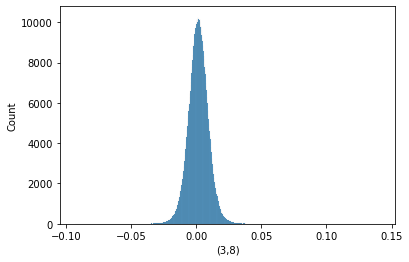

In [33]:
import seaborn as sns
sns.histplot(strain_traj.xs('exz', level='values').loc[idx]['(3,8)'])

In [34]:
strain_traj.xs('exz', level='values').loc[idx]['(3,8)'].describe()

count    907539.000000
mean          0.001688
std           0.007791
min          -0.092788
25%          -0.003132
50%           0.001685
75%           0.006500
max           0.140883
Name: (3,8), dtype: float64

In [228]:
_tmp = strain_traj.xs('exz', level='values').loc[idx]
out=[]
for t in [4,5,6,8]:
    out.append(200*_tmp['(3,{})'.format(t)].describe()['mean'])
out

[0.1166901847251969,
 0.17817131781481274,
 0.22009171772315778,
 0.3402235606838048]

In [35]:
#strain_traj.dropna().xs('exz',level='values')[strain_traj.dropna().xs('nnb count',level='values') > 9].dropna().index.get_level_values('particle')
pos

x (um, imageStack)  y (um, imageStack)  z (um, imageStack)  \
frame particle                                                               
0     0                  23.480112            2.221875           27.385583   
      1                  31.531264            2.180390           27.351286   
      2                  37.789111            2.119240           27.275850   
      3                  39.408522            2.436315           27.277841   
      4                  35.347537            2.748365           27.335966   
...                            ...                 ...                 ...   
89    1489977           200.492249          221.169243           71.848828   
      1489978           187.204307          202.418158           83.305471   
      1489979           188.845862          225.415862           83.684483   
      1489980           193.989494          194.780281           83.924158   
      1489981           186.063189          201.029539           85.103917   

                        x_std          y_std          z_std  
frame particle                                               
0     0              0.160625       0.149919       0.139626  
      1              0.121123       0.120859       0.108598  
      2              0.130098       0.134635       0.117372  
      3              0.110703       0.114330       0.101162  
      4              0.134831       0.134550       0.121837  
...                       ...            ...            ...  
89    1489977        0.121115       0.122348       0.104224  
      1489978             NaN            NaN            NaN  
      1489979        1.279382       0.922309       1.188493  
      1489980   119852.822302  111242.080747  128126.585762  
      1489981             NaN            NaN            NaN  

[87508017 rows x 6 columns]

### for interpolation we need a list of:
- points (x,y,z) coordinates 
- values of the quantitiy, in this case one of the strain components
- and the grid size and mesh spacing onto which the interpolation will occur

In [18]:
# interpolate the strain data with a given mesh spacing

from scipy.interpolate import griddata
posKeyList = ['{} (um, imageStack)'.format(x) for x in ['z','y','x']]

# get the points and note that the numpy output will be in whatever column order you called the columns
pts_zyx = pos.xs(3,level='frame').loc[idx][posKeyList].to_numpy()

# get exz comp of strain. note that you have to take cross section prior to loc otherwsie it crashes. 
# be careful taking loc on multiindex array. you can do it but you have to specfiy the multindex and not simply
# the particle index as if there were no other depth. 

vals_exz = strain_traj.xs('exz', level='values').loc[idx]['(3,8)'].to_numpy()

grid_z, grid_y, grid_x = np.mgrid[27:86:0.5, 0:235:0.5, 0:235:0.5 ]
interp= griddata(pts_zyx, vals_exz, (grid_z, grid_y, grid_x), method='linear')

In [19]:
# what fraction is filled with interpolated values? 
# The fact that this is not 100% is due to the grid exceeding sampling domain specified in pts_xyz
# I am a little surprised though that this is over 30% unfilled by 
# picking the bounds be max and mins of xyz components seprately.
# this filling fraction does not depend on the sampling mesh, which is good. I think its just a boundary effect
np.count_nonzero(~np.isnan(interp))/interp.flatten().shape[0]

0.93806320061996

In [20]:
raw_max, raw_min = np.percentile(interp[~np.isnan(interp)],99.9), np.percentile(interp[~np.isnan(interp)],0.1)

tmp = np.nan_to_num(interp, nan=1.1*raw_max)

In [21]:
tmp.max()
raw_max

0.028557038675005284

In [119]:
# visualize with pyFiji
from particleLocating import pyFiji
import tifffile
import pyperclip
from importlib import reload

In [121]:
reload(pyFiji)

<module 'particleLocating.pyFiji' from '/Users/zsolt/Colloid_git/TractionRheoscopy/particleLocating/pyFiji.py'>

In [38]:
import datetime
def send2Fiji(arrayList, wdir =None ,metaData=None):
    """ 
  This function takes a nparray or a list of np.array
  [+] writes each array to tif in wdir using a tmp.tif
  [+] creates an text object that contains a fiji macro
  [+] copies the macro to the system keyboard.
  After it runs, if you go to fiji and press fn-F1, fiji will take the text on system clipboard and run it as macro
  This last step is accomplished by creating a simple macro and mapping it it to F1 using fiji shortcut
  I also created a macro to close all windows in fiji and mapped that to F2.
    """
    if wdir is None: wdir = '/Volumes/TFR/tfrGel10212018A_shearRun10292018f/pyFiji/'
    def send2FijiSingleArray(nparray,index):
        dataStr = str(datetime.date.today())
        #path = flatField.array2tif(nparray,wdir+'/tmp_'+ dataStr + str(index)+'.tif',metaData=metaData)
        path = wdir+'tmp_{}.tif'.format(index)
        tifffile.imwrite(path,nparray)
        return 'open("'+ path +'");\n'
    macroText = ''
    if type(arrayList) == np.ndarray:
        macroText += send2FijiSingleArray(arrayList,0)
    elif type(arrayList) == list:
        for n in range(len(arrayList)): 
            macroText += send2FijiSingleArray(arrayList[n],n)
    pyperclip.copy(macroText)
    print("Images saved to tif and copied to system clipboard.")
    return macroText

In [235]:
send2Fiji(pyFiji.recastImage(tmp,{'min':3*raw_min,'max':3*raw_max}))

Images saved to tif and copied to system clipboard.


'open("/Volumes/TFR/tfrGel10212018A_shearRun10292018f/pyFiji/tmp_0.tif");\n'

In [44]:
# convert to dask array and set chunk size. 
import dask
chunk_zyx_um = np.array((25,25,25))
um2mesh = np.array((0.2,0.2,0.2))
chunk_zyx_interp = chunk_zyx_um/um2mesh
tmp_da = dask.array.from_array(tmp,chunks=chunk_zyx_interp)
tmp_da

dask.array<array, shape=(295, 550, 550), dtype=float64, chunksize=(125, 125, 125), chunktype=numpy.ndarray>

In [43]:
# map blocks 
# I am not currently sure how spatialCorr is going to treat the nan vlaues or what I should map those to before applying map blocks
#A_3d = da.arange(75**3).reshape((75,75,75)).rechunk(chunks=(15,15,15))
from data_analysis import eshelby_inclusion
k_um = np.array((10,10,10))
k_px = k_um/um2mesh
k_px.astype(int)

array([50, 50, 50])

In [243]:
autoCorr_3d = lambda x: eshelby_inclusion.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=True)
# n_workers=10, smaller array, I am running at 50% total cpu and about 500mb of ram per process.
# did not finish after 12 hours so I killed it. 
with LocalCluster(n_workers=10, threads_per_worker=6, memory_limit='5Gb') as node, Client(node) as client:
    out_overlap3D = tmp_da.map_overlap(autoCorr_3d, depth=40, dtype='float32', boundary='none').compute()

In [251]:
tmp.shape

(295, 550, 550)

In [18]:
%%time

mesh_dzyx_um = np.array((0.5,0.5,0.5))
posKeyList = ['{} (um, imageStack)'.format(x) for x in ['z','y','x']]

# get the points and note that the numpy output will be in whatever column order you called the columns
pts_zyx = pos.xs(3,level='frame').loc[idx][posKeyList].to_numpy()

# get exz comp of strain. note that you have to take cross section prior to loc otherwsie it crashes. 
# be careful taking loc on multiindex array. you can do it but you have to specfiy the multindex and not simply
# the particle index as if there were no other depth. 

vals_exz = strain_traj.xs('exz', level='values').loc[idx]['(3,8)'].to_numpy()

grid_z, grid_y, grid_x = np.mgrid[27:86:mesh_dzyx_um[0], 1:234:mesh_dzyx_um[1], 1:234:mesh_dzyx_um[2] ]
interp = griddata(pts_zyx, vals_exz, (grid_z, grid_y, grid_x), method='linear')

# clip any boundaries to 0
tmp = np.nan_to_num(interp, nan=1)

CPU times: user 47.4 s, sys: 1.57 s, total: 48.9 s
Wall time: 48.9 s


In [23]:
tmp.shape

(118, 466, 466)

In [19]:
tmp2 = np.zeros((120,460,460))
tmp2[1:tmp.shape[0]+1,:,:] = tmp[:,3:tmp.shape[2]-3,3:tmp.shape[2]-3]

In [20]:
tmp2.shape/np.array((40,46,46))

array([ 3., 10., 10.])

In [22]:

chunk_dzyx = np.array((20,23,23)) # 20 um chunk
chunk_px = chunk_dzyx/mesh_dzyx_um
l = (tmp.shape/np.array(2) - chunk_px/2).astype(int)
r = (tmp.shape/np.array(2) + chunk_px/2).astype(int)
l,r 

(array([ 39, 210, 210]), array([ 79, 256, 256]))

### Profile a single chunk, "manually" without dask

In [24]:
# cut out the chunk into a separate array
tmp_middleChunk = tmp[l[0]:r[0],l[1]:r[1], l[2]:r[2]]
#tmp_da = dask.array.from_array(tmp_middleChunk,chunks=chunk_zyx_interp)
chunk_da = dask.array.from_array(tmp_middleChunk,chunks=(40,46,46))

k_um = np.array((9,10,10))
k_px = k_um/mesh_dzyx_um
k_px.astype(int)
chunk_da

dask.array<array, shape=(40, 46, 46), dtype=float64, chunksize=(40, 46, 46), chunktype=numpy.ndarray>

In [25]:
%%time
# took 30 secs on 1 thread...there is clearly something wrong with dask and map blocks. 
autoCorr_3d = lambda x: slb.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
out_chunk = autoCorr_3d(tmp_middleChunk)
#with LocalCluster(n_workers=15, threads_per_worker=6, memory_limit='2Gb') as node, Client(node) as client:
#    out_overlap3D = tmp_da.map_overlap(autoCorr_3d, depth=20, dtype='float32',chunks=np.array((2*k_px[0]+1, 2*k_px[1]+1, 2*k_px[2]+1)).astype(int)).compute()

CPU times: user 27.2 s, sys: 115 ms, total: 27.3 s
Wall time: 27.3 s


In [26]:
%%time
# how much time does overlap add? takes about 2 min
overlap_px = 20
tmp_overlap = tmp[l[0]-10:r[0]+10,l[1]-10:r[1]+10, l[2]-10:r[2]+10]
autoCorr_3d = lambda x: slb.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
out_chunkOverlap = autoCorr_3d(tmp_overlap)

In [79]:
%%time
# what if we use mapblocks on a single chunk? 

# took 30 secs on 1 thread...there is clearly something wrong with dask and map blocks. 
autoCorr_3d = lambda x: slb.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
#out_chunk = autoCorr_3d(tmp_middleChunk)
with LocalCluster(n_workers=1, threads_per_worker=6, memory_limit='2Gb') as node, Client(node) as client:
    out_overlap3D = chunk_da.map_blocks(autoCorr_3d, dtype='float32').astype(int).compute()

CPU times: user 5.24 s, sys: 313 ms, total: 5.56 s
Wall time: 34.8 s


In [84]:
# map blocks on 4 chunks with 4 cores
_n = np.array((1,1,1)).astype(int)
n = _n*chunk_px.astype(int)

In [88]:
%%time
tmp_middleChunk = tmp[l[0]:r[0]+n[0],l[1]:r[1]+n[1], l[2]:r[2]+n[2]]
chunk_da = dask.array.from_array(tmp_middleChunk,chunks=(40,46,46))
#chunk_da
autoCorr_3d = lambda x: slb.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
#out_chunk = autoCorr_3d(tmp_middleChunk)
with LocalCluster(n_workers=4, threads_per_worker=6, memory_limit='2Gb') as node, Client(node) as client:
    out_overlap3D = chunk_da.map_blocks(autoCorr_3d, dtype='float32').astype(int).compute()
    
# Table of results
# 8 chunks on 8 cores, as expect 30sec
# 8 chunks on 4 cores, as expected 56 sec.

Task was destroyed but it is pending!
task: <Task pending coro=<HTTP1ServerConnection._server_request_loop() running at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/http1connection.py:817> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f843479c3d0>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/ioloop.py:690]>
Task was destroyed but it is pending!
task: <Task pending coro=<HTTP1ServerConnection._server_request_loop() running at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/http1connection.py:817> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f7d08238350>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/ioloop.py:690]>
Task was destroyed but it is pending!
task: <Task pending coro=<RequestHandler._execute() running at /Users/zs

CPU times: user 1.77 s, sys: 441 ms, total: 2.21 s
Wall time: 56.1 s


In [93]:
%%time
# lets try dask overlap, maybe thats the issue
# 4 chunks
_n = np.array((0,1,1)).astype(int)
n = _n*chunk_px.astype(int)

tmp_middleChunk = tmp[l[0]:r[0]+n[0],l[1]:r[1]+n[1], l[2]:r[2]+n[2]]
chunk_da = dask.array.from_array(tmp_middleChunk,chunks=(40,46,46))
chunk_da

autoCorr_3d = lambda x: slb.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
with LocalCluster(n_workers=4, threads_per_worker=6, memory_limit='2Gb') as node, Client(node) as client:
    out_overlap3D = chunk_da.map_overlap(autoCorr_3d, depth=20, dtype='float32',chunks=np.array((2*k_px[0]+1, 2*k_px[1]+1, 2*k_px[2]+1)).astype(int)).compute()
    
# resutls, 5min 47 secs. 
# Longer than I expected for a single chunk, but maybe thats becasue depth overlap is actually 20 on each side as opposed to 20 total
# While longer than I expected, it does not explain the 24 hour run time

CPU times: user 15.8 s, sys: 2.67 s, total: 18.5 s
Wall time: 5min 47s


In [114]:
%%time
# lets try dask overlap, maybe thats the issue
# 4 chunks
_n = np.array((1,1,1)).astype(int)
n = _n*chunk_px.astype(int)

tmp_middleChunk = tmp[l[0]:r[0]+n[0],l[1]:r[1]+n[1], l[2]:r[2]+n[2]]
chunk_da = dask.array.from_array(tmp_middleChunk,chunks=(40,46,46))
chunk_da

#from dask.diagnostics import ProgressBar
autoCorr_3d = lambda x: slb.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
with LocalCluster(n_workers=8, threads_per_worker=6, memory_limit='2Gb') as node, Client(node) as client, ProgressBar():
    out_overlap3D = chunk_da.map_overlap(autoCorr_3d, depth=3, dtype='float32',chunks=np.array((2*k_px[0]+1, 2*k_px[1]+1, 2*k_px[2]+1)).astype(int)).compute()

# results
# 4 chunks, depth 10, 4 cores : 1 min 51s --right in line with what a single chunk takes without dask
# 4 chunk, depth 10, 2 cores: 3 min 21s -- better than expected, owing to less initialization time. 
# 18 chunks, depth 10, 15 cores, including f
# 8 chunks, depth 3, 8 cores: 51 sec

CPU times: user 2.88 s, sys: 753 ms, total: 3.63 s
Wall time: 51.6 s


In [115]:
%%time
tmp2 = np.zeros((120,460,460))
tmp2[1:tmp.shape[0]+1,:,:] = tmp[:,3:tmp.shape[2]-3,3:tmp.shape[2]-3]
tmp_da = dask.array.from_array(tmp2,chunks=(40,46,46))
tmp_da # 300 tasks, chunk size (40,46,46) with (3,10,10) chunks
#k_px #[18, 20, 20]

autoCorr_3d = lambda x: slb.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
with LocalCluster(n_workers=15, threads_per_worker=6, memory_limit='2Gb') as node, Client(node) as client:
    out_overlap3D = tmp_da.map_overlap(autoCorr_3d, depth=3, dtype='float32',chunks=np.array((2*k_px[0]+1, 2*k_px[1]+1, 2*k_px[2]+1)).astype(int)).compute()

# results
# my expectation is that the full image with depth 3 should take 20 min on 15 cores, actual 24 min! not bad

Task was destroyed but it is pending!
task: <Task pending coro=<RequestHandler._execute() running at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/web.py:1703> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f7d0824a5d0>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/web.py:2333]>
Task was destroyed but it is pending!
task: <Task pending coro=<HTTP1ServerConnection._server_request_loop() running at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/http1connection.py:817> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f7c781aaa90>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/tornado/ioloop.py:690]>
Task was destroyed but it is pending!
task: <Task pending coro=<RequestHandler._execute() running at /Users/zsolt/.conda/envs/tractionR

CPU times: user 5min 7s, sys: 40.8 s, total: 5min 48s
Wall time: 24min 28s


In [131]:
# save to h5 file 
#import h5py

corrPath = '/Volumes/TFR/tfrGel10212018A_shearRun10292018f/strainCorrelation/'
fName_frmt = 'strainAutoCorr_{strainComp}_ref{ref}_cur{cur}.h5'
metaData = {'strainComp':'exz', 'ref': 3, 'cur': 8}
metaData.keys()
fName_frmt.format(**metaData)

'strainAutoCorr_exz_ref3_cur8.h5'

In [97]:
with h5py.File(corrPath + fName_frmt.format('xz',3,8))

#### Comments 
- I think there is something I dont understand about how Dask map_overlap is working. 
- I think map_overlap shold work, maybe with a bit more overhead, just like splitting the array into overlapping   chunks and then sending each chunk to a autoCorr_3d and saving the output. 
- This is clearly not what is happening as the timing on a single chunk is 30sec-2min depending on the size of
  of the array, while map_overlap applied to the chunks took 24 hrs and didnt finish.  
- Should I just use multiprocessing? Or try to figure out why dask isnt working the way I expect? 
- Update: I have no idea why this didnt work with dask. It certainly seems to be working as epected for smaller test cases
          with embarrassingly parallel scaling. 
- I am just going to try again. 
- UPDATE: I think the problem is very poor scaling with subarray size. Its best to keep the arrays small (say 50px on each side, and then scale the interpolation get longer or shorter range features...and if there is a region in shift vectors that you want high resolution (say 200nm spacing) and long range (20um) then only run the computation on the plane you're visualizing (and bite the bullet if its expensive...like a few min per k-point)
- At that level, its probably best to parallelize the kpoint computaiton as opposed to just the region as I am currently doing with map blocks. 

In [58]:
### Reproduce some errors
## Dask map blocks and map overlap really do work on a block and reassemble the result
# so why doesn't it parallelize the way it should? It can't figure out the right steps?
# it tries communicating? It really should be embarrassingly parallel. 
# maybe it is computing a correlation for every pair of blocks? Somehow its not a problem with map_overlap
# but rather I need two arrays. 
# or maybe it was running block corr with whole? 
# or maybe it wasnt dealing with the boundaries incorrectly and got a few spurious, very large arrays to compute on.
def avgBlock(block):
    out = np.zeros_like(block)
    for n in range(len(block)):
        #print(n)
        out[n] = np.mean(block[:n+1])
    return out

A = da.arange(10,chunks=5).astype('float')
avgBlock(np.arange(10).astype('float')), np.arange(10)

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [63]:
out = A.map_blocks(avgBlock).compute()
out_overlap = A.map_overlap(avgBlock,depth=1).compute()
out,out_overlap

(array([0. , 0.5, 1. , 1.5, 2. , 5. , 5.5, 6. , 6.5, 7. ]),
 array([0.        , 0.33333333, 0.75      , 1.2       , 1.66666667,
        4.5       , 5.        , 5.5       , 6.        , 6.5       ]))

In [75]:
g = da.overlap.overlap(A,depth=2,boundary='none')
np.array(g)
#g.map_blocks(avgBlock).compute()

(array([0., 1., 2., 3., 4., 5., 6., 3., 4., 5., 6., 7., 8., 9.]),
 dask.array<overlap, shape=(14,), dtype=float64, chunksize=(7,), chunktype=numpy.ndarray>)

In [28]:
tmp_overlap.shape, k_px
#k_px

((60, 66, 66), array([18., 20., 20.]))

In [56]:
chunk_zyx_interp = np.array((40,46,46))
tmp_da = dask.array.from_array(tmp2,chunks=chunk_zyx_interp)
tmp_da

dask.array<array, shape=(120, 460, 460), dtype=float64, chunksize=(40, 46, 46), chunktype=numpy.ndarray>

In [363]:
k_px

array([18., 20., 20.])

In [ ]:
# This took slighly more than 24 hours and safari crashed 
# leaving the computation running but the output dangling. 
#I killed it. I suspect it would have completed in less than 36 hours, 
# however the approach needs to be updated. I am not convinced I am on the right track
# with dask as these computations should not be taking this long on 15 cores. I assumed 
# that each chunk was sent to a core separately, but if thats true a single chunk
# would take 15*36/300 = 1.8 hours, which seems ridiculous for an autocorrelation of a
# matrix of 50x50x50 px over 18x20x20 shift vectors. 
# Back to the drawing board. I am going to check this explicitly without dask..amybe my 
# function really does take that long to run in which case I should switch to 
# only running autocorrelations on planes (0,ky,kx), (kz,0,kx) and (kz,ky,0) and maybe 
# some random samples elsewhere. 
# RAM usage was ok though. Maybe if there is a problem with dask, then perhaps I can just use the 
#simple multiprocessing to parallelize and
# save the output to a list of labeled files...old school hash based parallelization.
#
# Suggesting that one chunk of size (40,44,40) takes about 8 min and ~500MB (<2Gb) of ram on a single thread. 
# This processes 20*20*18 = 7200 kpoints on a grid of size 
autoCorr_3d = lambda x: eshelby_inclusion.spatialCorr_daskWrapper(x, x, k_px.astype(int), corrFunc='forLoop', padOut=False)
with LocalCluster(n_workers=15, threads_per_worker=6, memory_limit='2Gb') as node, Client(node) as client:
    out_overlap3D = tmp_da.map_overlap(autoCorr_3d, depth=20, dtype='float32',chunks=np.array((2*k_px[0]+1, 2*k_px[1]+1, 2*k_px[2]+1)).astype(int)).compute()

In [318]:
out = eshelby_inclusion.spatialCorr_daskWrapper(tmp_middleChunk, tmp_middleChunk, k_px.astype(int), corrFunc='forLoop', padOut=True)

NameError: name 'tmp_da' is not defined

In [319]:
out.shape

(50, 50, 50)

In [123]:
reload(pyFiji)
from particleLocating import pyFiji
tmpDir = ''
pyFiji.send2Fiji(pyFiji.recastImage(out_overlap3D,{'min':-1.01,'max':1.01}))

Images saved to tif and copied to system clipboard.


'open("/Volumes/TFR/tfrGel10212018A_shearRun10292018f/pyFiji/tmp_0.tif");\n'

In [297]:
# visualize with pyfiji. 

6012648

In [291]:
27+55

82

In [308]:
pos.xs(0,level='frame')[posKeyList].describe()

,"z (um, imageStack)","y (um, imageStack)","x (um, imageStack)"
count,156695.000000,156695.000000,156695.000000
mean,55.414312,117.274432,117.884553
std,15.687715,26.192660,26.226808
min,27.507163,62.380020,62.960281
25%,42.151450,96.203895,96.823130
50%,55.066477,117.348836,117.889259
75%,68.356857,138.250619,139.060591
max,86.964394,172.278633,172.691347


In [252]:
np.mgrid[1:10:100j]

array([ 1.        ,  1.09090909,  1.18181818,  1.27272727,  1.36363636,
        1.45454545,  1.54545455,  1.63636364,  1.72727273,  1.81818182,
        1.90909091,  2.        ,  2.09090909,  2.18181818,  2.27272727,
        2.36363636,  2.45454545,  2.54545455,  2.63636364,  2.72727273,
        2.81818182,  2.90909091,  3.        ,  3.09090909,  3.18181818,
        3.27272727,  3.36363636,  3.45454545,  3.54545455,  3.63636364,
        3.72727273,  3.81818182,  3.90909091,  4.        ,  4.09090909,
        4.18181818,  4.27272727,  4.36363636,  4.45454545,  4.54545455,
        4.63636364,  4.72727273,  4.81818182,  4.90909091,  5.        ,
        5.09090909,  5.18181818,  5.27272727,  5.36363636,  5.45454545,
        5.54545455,  5.63636364,  5.72727273,  5.81818182,  5.90909091,
        6.        ,  6.09090909,  6.18181818,  6.27272727,  6.36363636,
        6.45454545,  6.54545455,  6.63636364,  6.72727273,  6.81818182,
        6.90909091,  7.        ,  7.09090909,  7.18181818,  7.27

In [234]:
idx_refConfig = pos.xs(0,level='frame').index
idx_refConfig
idx_traj = strain_traj.dropna().xs('exx',level='values').index.get_level_values('particle')
idx_traj

Int64Index([ 74955,  74956,  75057,  75063,  75068,  75071,  75078,  75079,
             75080,  75081,
            ...
            890255, 890262, 890280, 890282, 890289, 890301, 890311, 890312,
            890366, 890399],
           dtype='int64', name='particle', length=154201)

# SCRATCH

In [63]:
(2*k_px[0]+1, 2*k_px[1]+1, 2*k_px[2]+1)

(101.0, 101.0, 101.0)

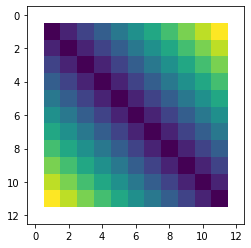

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt

# Q: does linear interpolation leaves gaps if mesh is too small?
# A: No
pts = [[0,0],[1,0],[0,1],[1,1]]
vals = [-1,1,1,-1]
grid_y, grid_x = np.mgrid[-0.1:1.1:0.1, -0.1:1.1:0.1]
interp = griddata(pts, vals, (grid_x, grid_y), method='linear')

plt.imshow(interp, interpolation='none')
plt.show()

In [30]:
def pearsonCor(A,B): return (np.mean(A * B) - np.mean(A) * np.mean(B)) / (np.sqrt(np.var(A)) * np.sqrt(np.var(B)))

In [31]:
pearsonCor(A,A)

1.0

In [96]:

kx, ky = (1,-1)
if kx > 0 and ky > 0 : a, b = A[ ky:,  kx: ], A[ :-1*ky, :-1*kx  ]
if kx > 0 and ky < 0: a, b = A[ :ky,  kx: ], A[ -1*ky:, :-1 * kx  ]
if kx < 0 and ky > 0: a, b = A[ ky:, :kx  ], A[ :-1*ky,  -1*kx: ]
if kx < 0 and ky < 0 :a, b = A[ :ky, :kx  ], A[ -1*ky:,  -1 * kx: ]

#a, b = A_random[ :  , :    ], A_random[ :, :         ]
#pearsonCor(a,b)
a_1n1, b_1n1  = a,b

In [100]:
a_11, a_n11, a_1n1,a_n1n1

(array([[11, 12, 13, 14, 15, 16, 17, 18, 19],
        [21, 22, 23, 24, 25, 26, 27, 28, 29],
        [31, 32, 33, 34, 35, 36, 37, 38, 39],
        [41, 42, 43, 44, 45, 46, 47, 48, 49],
        [51, 52, 53, 54, 55, 56, 57, 58, 59],
        [61, 62, 63, 64, 65, 66, 67, 68, 69],
        [71, 72, 73, 74, 75, 76, 77, 78, 79],
        [81, 82, 83, 84, 85, 86, 87, 88, 89],
        [91, 92, 93, 94, 95, 96, 97, 98, 99]]),
 array([[10, 11, 12, 13, 14, 15, 16, 17, 18],
        [20, 21, 22, 23, 24, 25, 26, 27, 28],
        [30, 31, 32, 33, 34, 35, 36, 37, 38],
        [40, 41, 42, 43, 44, 45, 46, 47, 48],
        [50, 51, 52, 53, 54, 55, 56, 57, 58],
        [60, 61, 62, 63, 64, 65, 66, 67, 68],
        [70, 71, 72, 73, 74, 75, 76, 77, 78],
        [80, 81, 82, 83, 84, 85, 86, 87, 88],
        [90, 91, 92, 93, 94, 95, 96, 97, 98]]),
 array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [11, 12, 13, 14, 15, 16, 17, 18, 19],
        [21, 22, 23, 24, 25, 26, 27, 28, 29],
        [31, 32, 33, 34, 35, 3

In [102]:
b_n1n1, b_1n1, b_n11, b_11

(array([[11, 12, 13, 14, 15, 16, 17, 18, 19],
        [21, 22, 23, 24, 25, 26, 27, 28, 29],
        [31, 32, 33, 34, 35, 36, 37, 38, 39],
        [41, 42, 43, 44, 45, 46, 47, 48, 49],
        [51, 52, 53, 54, 55, 56, 57, 58, 59],
        [61, 62, 63, 64, 65, 66, 67, 68, 69],
        [71, 72, 73, 74, 75, 76, 77, 78, 79],
        [81, 82, 83, 84, 85, 86, 87, 88, 89],
        [91, 92, 93, 94, 95, 96, 97, 98, 99]]),
 array([[10, 11, 12, 13, 14, 15, 16, 17, 18],
        [20, 21, 22, 23, 24, 25, 26, 27, 28],
        [30, 31, 32, 33, 34, 35, 36, 37, 38],
        [40, 41, 42, 43, 44, 45, 46, 47, 48],
        [50, 51, 52, 53, 54, 55, 56, 57, 58],
        [60, 61, 62, 63, 64, 65, 66, 67, 68],
        [70, 71, 72, 73, 74, 75, 76, 77, 78],
        [80, 81, 82, 83, 84, 85, 86, 87, 88],
        [90, 91, 92, 93, 94, 95, 96, 97, 98]]),
 array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [11, 12, 13, 14, 15, 16, 17, 18, 19],
        [21, 22, 23, 24, 25, 26, 27, 28, 29],
        [31, 32, 33, 34, 35, 3

In [49]:
(np.mean(a*b) - np.mean(a)*np.mean(b))/(np.sqrt(np.var(a))*np.sqrt(np.var(b)))

1.0